# K-Nearest Neighbor Lab





In [638]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd
from sklearn import preprocessing
import time as time
from sklearn.model_selection import train_test_split

# so I don't get a future warning cropping up each time. 
import warnings
warnings.filterwarnings("ignore") 

## 1. (40%) Correctly implement the k-nearest neighbor (KNN) algorithm and the KNN regression algorithm

### Code requirements
- Use Euclidean distance to decide closest neighbors. 
- Include optional distance weighting for both algorithms


In [577]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, K, columntype=[], weight_type='inverse_distance', metric = "2_norm"): ## add parameters here
        """
        Args:
            columntype for each column tells you if continues[real] or if nominal[categoritcal].
            weight_type: inverse_distance voting or if non distance weighting. Options = ["no_weight","inverse_distance"]
        """
        self.columntype = columntype #Note This won't be needed until part 5
        self.weight_type = weight_type
        self.K = K
        self.metric = metric

    def fit(self, X, y, normalize = False, regression = False):
        """ Fit the data; run the algorithm (for this lab really just saves the data :D)
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        
        self.regression = regression
        if normalize:
            self.X_train = self.normalize_dataset(X.values)
            self.y_train = y.values
        else:
            self.X_train = X.values # Data
            self.y_train = y.values # Labels
        
        
        self.normalize = normalize
        return self
    
    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the testing data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        all_labels = list(set(self.y_train))
        X_test = X.values
        
        preds = []
        labels = dict()
        
        if self.normalize:
            X_test = self.normalize_dataset(X_test)
        
        for test in X_test:
            distances = dict()
            if self.metric == "2_norm":
                norms = np.linalg.norm(test - self.X_train, axis = 1)
                
            elif self.metric == "custom":
                norms = []
                for row in self.X_train:
                    norm = 0
                    for j in range(len(row)):
                        if row[j] == None or test[j] == None:
                            norm += 1
                        elif isinstance(row[j], float):
                            if row[j] != test[j]:
                                a = row[j]/(row[j] + test[j])
                                b = test[j]/(row[j] + test[j])
                                norm += np.linalg.norm(a - b)
                        elif isinstance(row[j], bytes):
                            if row[j] != test[j]:
                                norm += 1
                    
                    norms.append(norm)
            
            for i in range(len(norms)):
                distances[i] = norms[i]
            sorted_distances = sorted(distances.items(), key = lambda x: x[1]) # sort by norm
            
            closest_labels = dict() # maps norm to label
            inds = [i[0] for i in sorted_distances[:self.K]]
            norm = [i[1] for i in sorted_distances[:self.K]]
            for i,n in zip(inds, norm):
                closest_labels[n] = self.y_train[i]
            
            
            if self.regression:
                 # ------Weighted------
                if self.weight_type == "inverse_distance":
                    # sum of 1/distance**2 * regression label) / sum of 1/distance**2 for all neighbors
                    numer = sum([closest_labels[d]/(d**2) for d in closest_labels.keys()])
                    denom = sum([1 / (d**2) for d in closest_labels.keys()])
                    preds.append(numer / denom)
                
                
                
                # ------Not Weighted------
                elif self.weight_type == "no_weight":
                    # average label of neighbors:
                    labels = list(closest_labels.values())
                    preds.append(np.mean(labels))
                
            else: # Classification case
                # ------Weighted------
                if self.weight_type == "inverse_distance":
                    inv_closest_labels = {(1 / (d**2)): closest_labels[d] for d in closest_labels.keys()} # Maps 1/norm^2 to label
                    labels = set(inv_closest_labels.values())


                    counts = dict() # Maps label to sum

                    for l in labels:
                        s = 0
                        for key, val in inv_closest_labels.items():
                            if val == l:
                                s += key
                        counts[l] = s

                    preds.append(max(counts, key=counts.get))

                # ------Not Weighted------
                elif self.weight_type == "no_weight":
                    # If all 3 closest neighbors have different labels, choose the label of the closest point
                    if len(set(closest_labels.values())) == 3:
                        preds.append(list(closest_labels.values())[0])

                    # Otherwise, just choose the label that appears most often among 3 closest neighbors
                    else:
                        counts = [list(closest_labels.values()).count(l) for l in all_labels]
                        preds.append(all_labels[np.argmax(counts)])
                    
        return preds
       


    #Returns the Mean score given input data and labels
    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        if self.regression:
            return np.mean([(self.predict(X)[i] - y.values[i])**2 for i in range(len(y.values))])
        
        
        else:
            count = 0

            for p,t in zip(self.predict(X), y.values):
                if p == t:
                    count += 1
            return count / len(y.values)
    
    
    # Helper functions for normalizing the data
    def dataset_minmax(self, dataset):
        minmax = list()
        for i in range(len(dataset[0])):
            col_values = [row[i] for row in dataset]
            value_min = min(col_values)
            value_max = max(col_values)
            minmax.append([value_min, value_max])
        return minmax
    
    def normalize_dataset(self, dataset):
        minmax = self.dataset_minmax(dataset)
        for row in dataset:
            for i in range(len(row)):
                row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
        return dataset

    

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below:

- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

---

### 1.1.1 Debug

- Use this [glass training set](https://byu.instructure.com/courses/14142/files?preview=4660939) and this [glass test set](https://byu.instructure.com/courses/14142/files?preview=4660941)
- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

Expected Results:
- Not using inverse weighted distancing = roughly [68.29%]
- Link to [glass no_inverse debug solution](https://byu.instructure.com/courses/14142/files?preview=4660947)

- Using inverse weighted distancing = roughly [74.39%]
- Link to [glass inverse debug solution](https://byu.instructure.com/courses/14142/files?preview=4660954)


In [511]:
# Load glass data
debug_data_train = arff.loadarff('glass_train.arff')
debug_df_train = pd.DataFrame(debug_data_train[0])

features_train = list(debug_df_train.columns)
X_train = debug_df_train[features_train[0:-1]]
y_train = debug_df_train[features_train[-1]]

debug_data_test = arff.loadarff('glass_test.arff')
debug_df_test = pd.DataFrame(debug_data_test[0])

features_test = list(debug_df_test.columns)
X_test = debug_df_test[features_test[0:-1]]
y_test = debug_df_test[features_test[-1]]

# ------------No weight------------
# Train on training set
knn = KNNClassifier(K = 3, weight_type = "no_weight")
knn.fit(X_train, y_train)

# Predict on test set
# knn.predict(X_test)
print(f"Accuracy not using inverse weighting: \n\t{np.round(100*knn.score(X_test, y_test), 4)}%")
print("")
# # ------------Using inverse_distance------------
# # Train on training set
knn = KNNClassifier(K = 3, weight_type = "inverse_distance")
knn.fit(X_train, y_train)

# Predict on test set
# knn.predict(X_test)
print(f"Accuracy using inverse weighting: \n\t{np.round(100*knn.score(X_test, y_test), 4)}%")


Accuracy not using inverse weighting: 
	71.9512%

Accuracy using inverse weighting: 
	74.3902%


### 1.1.2 Evaluate

We will evaluate your model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [diabetes training set](https://byu.instructure.com/courses/14142/files?preview=4660977) and this [diabetes test set](https://byu.instructure.com/courses/14142/files?preview=4660978)

In [465]:
# Load diabetes data
eval_data_train = arff.loadarff('diabetes_train.arff')
eval_df_train = pd.DataFrame(eval_data_train[0])

features_train = list(eval_df_train.columns)
X_train = eval_df_train[features_train[0:-1]]
y_train = eval_df_train[features_train[-1]]

eval_data_test = arff.loadarff('diabetes_test.arff')
eval_df_test = pd.DataFrame(eval_data_test[0])

features_test = list(eval_df_test.columns)
X_test = eval_df_test[features_test[0:-1]]
y_test = eval_df_test[features_test[-1]]

# Train on training set
knn = KNNClassifier(K = 3, weight_type = "inverse_distance")
knn.fit(X_train, y_train)

# Predict on test set
knn.predict(X_test)
print(f"Accuracy using inverse weighting: \n\t{np.round(100*knn.score(X_test, y_test), 4)}%")


Accuracy using inverse weighting: 
	89.0625%


## 2. (10%) Use the k-nearest neighbor algorithm (without distance weighting) for the [magic telescope](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) problem

- Use this [magic telescope training set](https://byu.instructure.com/courses/14142/files?preview=4660988) and this [magic telescope test set](https://byu.instructure.com/courses/14142/files?preview=4660989) 

### 2.1
- Try it with k=3 and without normalization


In [639]:
# Load magic telescope data
magic_data_train = arff.loadarff('magic_telescope_train.arff')
magic_df_train = pd.DataFrame(magic_data_train[0])

features_train = list(magic_df_train.columns)
X_train = magic_df_train[features_train[0:-1]]
y_train = magic_df_train[features_train[-1]]

magic_data_test = arff.loadarff('magic_telescope_test.arff')
magic_df_test = pd.DataFrame(magic_data_test[0])

features_test = list(magic_df_test.columns)
X_test = magic_df_test[features_test[0:-1]]
y_test = magic_df_test[features_test[-1]]
# Train/Predict without normalization

knn = KNNClassifier(K = 3, weight_type = "no_weight")
knn.fit(X_train, y_train)

print(f"Accuracy using no inverse weighting, and no normalization: \n\t{np.round(100*knn.score(X_test, y_test), 4)}%")

Accuracy using no inverse weighting, and no normalization: 
	80.8281%


### 2.2
- Try it with k=3 and with normalization (input features normalized between 0 and 1). Use the normalization formula (x-xmin)/(xmax-xmin)

In [640]:
# Train/Predict with normalization
knn = KNNClassifier(K = 3, weight_type = "no_weight")
knn.fit(X_train, y_train, normalize = True)

print(f"Accuracy using no inverse weighting, and normalization: \n\t{np.round(100*knn.score(X_test, y_test), 4)}%")

Accuracy using no inverse weighting, and normalization: 
	81.5782%


*Discuss the accuracy results of using normalized data vs. unnormalized data*

Here, with the same K value, accuracy increased slightly after normalizing data. This indicates that there were a few outliers "skewing" the results, and that after normalizing, have less of an effect on accuracy.

### 2.3

- Using your normalized data, create one graph with classification accuracy on the test set over k values. 
    - Use odd values of k from 1 to 15.
- As a rough sanity check, typical knn accuracies for the magic telescope data set are 75-85%

In [482]:
# Train/Predict with normalization using k=1,3,...,15
k_vals = [2*i + 1 for i in range(8)]
accuracy_vals = []
for k in k_vals:
    knn = KNNClassifier(K = k, weight_type = "no_weight")
    knn.fit(X_train, y_train, normalize = True)
    accuracy_vals.append(100*knn.score(X_test, y_test))
    


Text(0, 0.5, 'Accuracy')

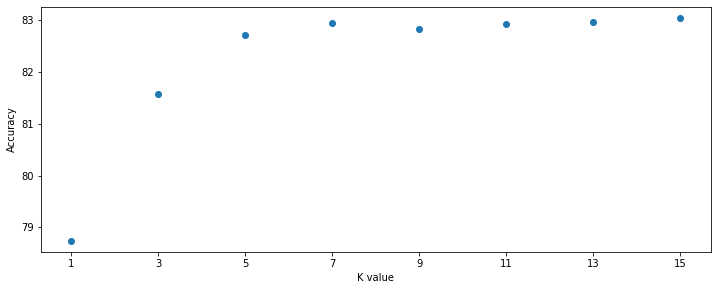

In [490]:
# Graph classification accuracy over k
plt.figure(figsize = (12,4.5))
plt.scatter(k_vals, accuracy_vals)
plt.xticks(k_vals)
plt.xlabel("K value")
plt.ylabel("Accuracy")

# For the rest of the experiments use only normalized data

## 3. (10%) Use the regression variation of your algorithm (without distance weighting) for the [housing price prediction](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) problem.

- Use this [housing training set](https://byu.instructure.com/courses/14142/files?preview=4660994) and this [housing test set](https://byu.instructure.com/courses/14142/files?preview=4660995).
- Use Mean Square Error (MSE) on the test set as your accuracy metric for this case.
    - Do not normalize regression output values
- Graph MSE on the test set with odd values of k from 1 to 15


In [573]:
# Load housing price prediction data
house_data_train = arff.loadarff('housing_train.arff')
house_df_train = pd.DataFrame(house_data_train[0]).astype(float)
# house_df_train["CHAS"] = house_df_train["CHAS"].astype(int)

features_train = list(house_df_train.columns)
X_train = house_df_train[features_train[0:-1]] # Data
y_train = house_df_train[features_train[-1]] # Regression label

house_data_test = arff.loadarff('housing_test.arff')
house_df_test = pd.DataFrame(house_data_test[0]).astype(float)
# house_df_test["CHAS"] = house_df_test["CHAS"].astype(int)

features_test = list(house_df_test.columns)
X_test = house_df_test[features_test[0:-1]]
y_test = house_df_test[features_test[-1]]

# Train/Predict using k=1,3,...,15
k_vals = [2*i + 1 for i in range(8)]
mse_vals = []
for k in k_vals:
    knn = KNNClassifier(K = k, weight_type = "no_weight")
    knn.fit(X_train, y_train, normalize = True, regression = True)
    mse_vals.append(knn.score(X_test, y_test))


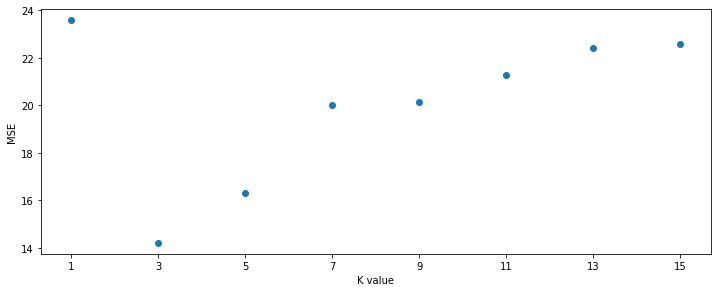

In [575]:
# Graph MSE over k
plt.figure(figsize = (12,4.5))
plt.scatter(k_vals, mse_vals)
plt.xticks(k_vals)
plt.xlabel("K value")
plt.ylabel("MSE")
plt.show()

## 4. (15%) Repeat your experiments for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss your results.


## 4.1 Magic Telescope Dataset

In [565]:
# Train/Predict magic telescope using distance-weighted voting
magic_data_train = arff.loadarff('magic_telescope_train.arff')
magic_df_train = pd.DataFrame(magic_data_train[0])

features_train = list(magic_df_train.columns)
X_train = magic_df_train[features_train[0:-1]]
y_train = magic_df_train[features_train[-1]]

magic_data_test = arff.loadarff('magic_telescope_test.arff')
magic_df_test = pd.DataFrame(magic_data_test[0])

features_test = list(magic_df_test.columns)
X_test = magic_df_test[features_test[0:-1]]
y_test = magic_df_test[features_test[-1]]

k_vals = [2*i + 1 for i in range(8)]
accuracy_vals = []
for k in k_vals:
    knn = KNNClassifier(K = k, weight_type = "inverse_distance")
    knn.fit(X_train, y_train, normalize = True)
    accuracy_vals.append(100*knn.score(X_test, y_test))
    

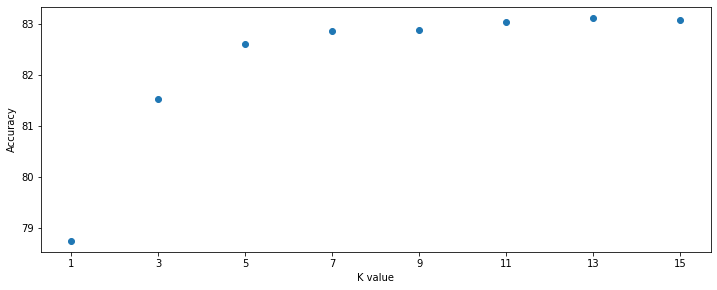

In [568]:
plt.figure(figsize = (12,4.5))
plt.scatter(k_vals, accuracy_vals)
plt.xticks(k_vals)
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.show()

## 4.2 Housing Dataset

In [571]:
# Train/Predict housing using distance-weighted voting
# Load housing price prediction data
house_data_train = arff.loadarff('housing_train.arff')
house_df_train = pd.DataFrame(house_data_train[0]).astype(float)
# house_df_train["CHAS"] = house_df_train["CHAS"].astype(int)

features_train = list(house_df_train.columns)
X_train = house_df_train[features_train[0:-1]] # Data
y_train = house_df_train[features_train[-1]] # Regression label

house_data_test = arff.loadarff('housing_test.arff')
house_df_test = pd.DataFrame(house_data_test[0]).astype(float)
# house_df_test["CHAS"] = house_df_test["CHAS"].astype(int)

features_test = list(house_df_test.columns)
X_test = house_df_test[features_test[0:-1]]
y_test = house_df_test[features_test[-1]]

# Train/Predict using k=1,3,...,15
k_vals = [2*i + 1 for i in range(8)]
mse_vals = []
for k in k_vals:
    knn = KNNClassifier(K = k, weight_type = "inverse_distance")
    knn.fit(X_train, y_train, normalize = True, regression = True)
    mse_vals.append(knn.score(X_test, y_test))


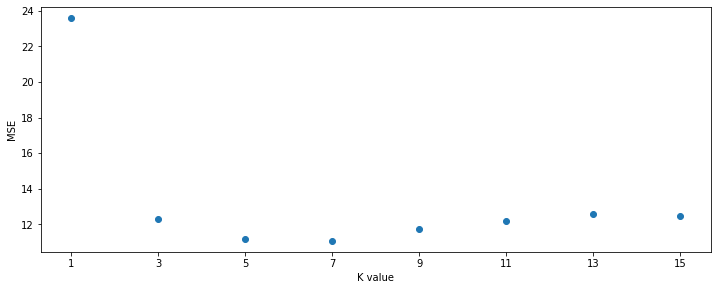

In [572]:
plt.figure(figsize = (12,4.5))
plt.scatter(k_vals, mse_vals)
plt.xticks(k_vals)
plt.xlabel("K value")
plt.ylabel("MSE")
plt.show()

*Discuss your results*

## 5. (10%) Use the k-nearest neighbor algorithm to solve the [credit-approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) (credit-a) problem.

- Use this [credit approval dataset](https://byu.instructure.com/courses/14142/files?preview=4660998)
    - Use a 70/30 split of the data for the training/test set
- Note that this set has both continuous and nominal attributes, together with don’t know values. 
- Implement and justify a distance metric which supports continuous, nominal, and don’t know attribute values
    - You need to handle don't knows with the distance metric, not by imputing a value.
    - More information on distance metrics can be found [here](https://www.jair.org/index.php/jair/article/view/10182/24168).
- Use your own choice for k.
- As a rough sanity check, typical knn accuracies for the credit data set are 70-80%.


In [597]:
# Load dataset and split into train/test sets
credit_data = arff.loadarff('credit_approval.arff')
credit_df = pd.DataFrame(credit_data[0])

features = list(credit_df.columns)
X = credit_df[features[0:-1]]
y = credit_df[features[-1]] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


# Train/Predict credit-approval

knn = KNNClassifier(K = 6, weight_type = "inverse_distance", metric = "custom")
knn.fit(X_train, y_train, normalize = False, regression = False)
print(f"Accuracy with k = 6: {knn.score(X_test, y_test)}")



Accuracy with k = 6: 0.8309178743961353


*Explain and justify your distance metric*

My distance metric adds a 1 to the norm if a single None value is encounterd. If a bytes value is encountered, then I make sure the values are not equal, then add a 1 to the norm.\
Finally, if both values are floats and are not equal to each other, I normalize each one and take the 2-norm (euclidian distance). \
This metric works because often a none value is compared to a int or float value and since we have no idea how far away those points are from each other, we choose 1. 1 is not very far nor is it very close when considering how close the float values are to each other. \
I chose k = 6 as that gave me the highest accuracy. 



## 6. (15%) Use the scikit's KNN Classifier on magic telescope and KNN Regressor on housing and compare your results.

- Try out different hyperparameters to see how well you can do. 


In [627]:
# Train/Predict magic telescope using scikit's KNN

le = preprocessing.LabelEncoder()

magic_data_train = arff.loadarff('magic_telescope_train.arff')
magic_df_train = pd.DataFrame(magic_data_train[0])

features_train = list(magic_df_train.columns)
X_train = magic_df_train[features_train[0:-1]]
y_train = le.fit_transform(magic_df_train[features_train[-1]])

magic_data_test = arff.loadarff('magic_telescope_test.arff')
magic_df_test = pd.DataFrame(magic_data_test[0])

features_test = list(magic_df_test.columns)
X_test = magic_df_test[features_test[0:-1]]
y_test = le.fit_transform(magic_df_test[features_test[-1]])

weights_vals = ["uniform", "distance"]
p_vals = [2,3,4]
neigh_vals = [3,5,7,9]
for k in neigh_vals:
    for p in p_vals:
        for weight in weights_vals:
            neigh = KNeighborsClassifier(n_neighbors=k, weights = weight, p = p)
            neigh.fit(X_train, y_train)
            print(f"With weights set to {weight}, and K = {k}, and p = {p}, accuracy is {neigh.score(X_test, y_test)}")

With weights set to uniform, and K = 3, and p = 2, accuracy is 0.8082808280828083
With weights set to distance, and K = 3, and p = 2, accuracy is 0.8094809480948095
With weights set to uniform, and K = 3, and p = 3, accuracy is 0.8052805280528053
With weights set to distance, and K = 3, and p = 3, accuracy is 0.8058805880588059
With weights set to uniform, and K = 3, and p = 4, accuracy is 0.804080408040804
With weights set to distance, and K = 3, and p = 4, accuracy is 0.8052805280528053
With weights set to uniform, and K = 5, and p = 2, accuracy is 0.8136813681368137
With weights set to distance, and K = 5, and p = 2, accuracy is 0.8166816681668166
With weights set to uniform, and K = 5, and p = 3, accuracy is 0.8120312031203121
With weights set to distance, and K = 5, and p = 3, accuracy is 0.8147314731473148
With weights set to uniform, and K = 5, and p = 4, accuracy is 0.8093309330933093
With weights set to distance, and K = 5, and p = 4, accuracy is 0.8115811581158116
With weight

Using distance weighting, k = 9 and p = 2, we get the best accuracy. k = 7 is a close second.

In [637]:
# Train/Predict housing using scikit's KNN
house_data_train = arff.loadarff('housing_train.arff')
house_df_train = pd.DataFrame(house_data_train[0]).astype(float)

features_train = list(house_df_train.columns)
X_train = house_df_train[features_train[0:-1]] # Data
y_train = house_df_train[features_train[-1]] # Regression label

house_data_test = arff.loadarff('housing_test.arff')
house_df_test = pd.DataFrame(house_data_test[0]).astype(float)

features_test = list(house_df_test.columns)
X_test = house_df_test[features_test[0:-1]]
y_test = house_df_test[features_test[-1]]


weights_vals = ["uniform", "distance"]
p_vals = [2,3,4]
neigh_vals = [3,5,7,9]
for k in neigh_vals:
    for p in p_vals:
        for weight in weights_vals:
            neigh = KNeighborsRegressor(n_neighbors=k, weights = weight, p = p)
            neigh.fit(X_train, y_train)
            print(f"With weights set to {weight}, and K = {k}, and p = {p}, R^2 is {neigh.score(X_test, y_test)}")



With weights set to uniform, and K = 3, and p = 2, R^2 is 0.3089347485187751
With weights set to distance, and K = 3, and p = 2, R^2 is 0.3114920892272527
With weights set to uniform, and K = 3, and p = 3, R^2 is 0.22292245846883407
With weights set to distance, and K = 3, and p = 3, R^2 is 0.23621892451869952
With weights set to uniform, and K = 3, and p = 4, R^2 is 0.21595385172966386
With weights set to distance, and K = 3, and p = 4, R^2 is 0.2277616504983757
With weights set to uniform, and K = 5, and p = 2, R^2 is 0.25491902354492035
With weights set to distance, and K = 5, and p = 2, R^2 is 0.2739381978953438
With weights set to uniform, and K = 5, and p = 3, R^2 is 0.17347095770627008
With weights set to distance, and K = 5, and p = 3, R^2 is 0.2062744711906369
With weights set to uniform, and K = 5, and p = 4, R^2 is 0.17666224642779838
With weights set to distance, and K = 5, and p = 4, R^2 is 0.20564006163348414
With weights set to uniform, and K = 7, and p = 2, R^2 is 0.297

*Report your comparison*

Clearly the classifier on magic telescope is much more accurate. However, it should be noted that the score metric on the regressor is neither accuracy nor MSE, it's rather an $R^2$ score. In other words, this $R^2$ score says how much variance can be explained by the data. Since this is fairly close to 0, it's safe to say that the "accuracy" is also not great.

## 7. (optional 5% extra credit): For the best value of k for any one of the datasets, implement a reduction algorithm that removes data points in some rational way such that performance does not drop too drastically on the test set given the reduced training set.

- Compare your performance on the test set for the reduced and non-reduced versions and give the number (and percentage) of training examples removed from the original training set. How well does your reduction algorithm work?
    - Note that performance for magic telescope is classification accuracy and for housing it is mean squared error.
    - Magic Telescope has about 12,000 instances and if you use a leave one out style of testing for your data set reduction, then your algorithm will run slow since that is n2 at each step.
    - If you wish, you may use a random subset of 2,000 of the magic telescope instances.
    - Examples of reduction techniques include: (a) leave-one-out reduction - Drop instance if it would still be classified correctly, (b) growth algorithm - Only add instance if it is not already classified correctly, (c) just keep central points, (d) just keep border points, etc. (see Wilson, D. R. and Martinez, T. R., Reduction Techniques for Exemplar-Based Learning Algorithms, Machine Learning Journal, vol. 38, no. 3, pp. 257-286, 2000).